<img src="https://raw.githubusercontent.com/jorgelizarazo94/BoutScout_Model/main/assets/logo.png" width="300px">

# Supplementary 1 - Dataset Preparation and Initial Modeling
**BoutScout: A Deep Learning Framework for Automatic Detection of Incubation Events in Avian Nests Using Temperature Time Series**

Author: [Jorge Lizarazo](https://www.researchgate.net/profile/Jorge-Lizarazo-Borrero?ev=hdr_xprf)


We detail here the final steps in preparing the incubation dataset and the construction of an initial exploratory model using an 80/20 train-test split. These procedures mark the transition between data curation and early modeling, allowing us to test model structure, depth, and core hyperparameters before advancing to more rigorous cross-validation. This phase is not meant to produce a production-ready model, but rather to explore architectural decisions such as the number of BiLSTM layers, hidden dimensions, and learning rate. Results from this stage inform decisions used in Supplementary 2, where cross-validation and full retraining are performed.

**Year:** 2025

## Final Dataset Assembly and Cleaning

In [21]:
import numpy as np
import glob
import os
import pandas as pd
import json
import ast
#
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import Dataset, DataLoader**File loading:** The files annotated by three different team members (`Pamela López`, `Mariana Torres`, and `Lizarazo`) are loaded using pandas.

In [2]:
file_names = [
    "G:/Thesis/pre_processing/Etiquetados_JL.csv",
    "G:/Thesis/pre_processing/Etiquetados_mariana.csv",
    "G:/Thesis/pre_processing/Etiquetados_pame.csv"
]



We load labeled temperature data from multiple annotators into a unified list for later merging.

In [3]:
list_of_dfs = []
for file_name in file_names:
    try:
        df = pd.read_csv(file_name, index_col=0, parse_dates=['date'])
        list_of_dfs.append(df)
    except FileNotFoundError:
        print(f"Advertencia: Archivo no encontrado: {file_name}")
    except Exception as e:
        print(f"Error al leer {file_name}: {e}")

In [4]:
if list_of_dfs:
    df_bloques_etiquetados = pd.concat(list_of_dfs, ignore_index=True)

    # 4. Mostrar enformasión básika del DataFrame kombinado
    print("--- DataFrame Combinado ---")
    print(f"Shape: {df_bloques_etiquetados.shape}")
    print("\nPrimeras filas:")
    print(df_bloques_etiquetados.head())
else:
    print("No se cargaron DataFrames para combinar. ocho ahi crack")

--- DataFrame Combinado ---
Shape: (6117349, 9)

Primeras filas:
                 date   tempe  ambient  \
0 2010-10-31 07:45:32  21.509   18.557   
1 2010-10-31 07:46:32  21.413   18.675   
2 2010-10-31 07:47:32  21.294   18.509   
3 2010-10-31 07:48:32  21.199   18.580   
4 2010-10-31 07:49:32  21.103   18.604   

                               archivo_origen      hour  hour_sin  hour_cos  \
0  Chlorospingus_flavigularis_SP28c_RVA10.csv  7.750000  0.896873 -0.442289   
1  Chlorospingus_flavigularis_SP28c_RVA10.csv  7.766667  0.894934 -0.446198   
2  Chlorospingus_flavigularis_SP28c_RVA10.csv  7.783333  0.892979 -0.450098   
3  Chlorospingus_flavigularis_SP28c_RVA10.csv  7.800000  0.891007 -0.453990   
4  Chlorospingus_flavigularis_SP28c_RVA10.csv  7.816667  0.889017 -0.457874   

        fecha label  
0  2010-10-31   Off  
1  2010-10-31   Off  
2  2010-10-31   Off  
3  2010-10-31   Off  
4  2010-10-31   Off  


In [5]:
print(df_bloques_etiquetados)

                       date   tempe  ambient  \
0       2010-10-31 07:45:32  21.509   18.557   
1       2010-10-31 07:46:32  21.413   18.675   
2       2010-10-31 07:47:32  21.294   18.509   
3       2010-10-31 07:48:32  21.199   18.580   
4       2010-10-31 07:49:32  21.103   18.604   
...                     ...     ...      ...   
6117344 2013-10-25 19:47:18  41.766  221.373   
6117345 2013-10-25 19:48:18  41.414  221.373   
6117346 2013-10-25 19:49:18  44.104  216.704   
6117347 2013-10-25 19:50:18  48.938  216.704   
6117348 2013-10-25 19:51:18  44.257  216.704   

                                       archivo_origen       hour  hour_sin  \
0          Chlorospingus_flavigularis_SP28c_RVA10.csv   7.750000  0.896873   
1          Chlorospingus_flavigularis_SP28c_RVA10.csv   7.766667  0.894934   
2          Chlorospingus_flavigularis_SP28c_RVA10.csv   7.783333  0.892979   
3          Chlorospingus_flavigularis_SP28c_RVA10.csv   7.800000  0.891007   
4          Chlorospingus_flavigul

We prepare to convert string labels into integers for model compatibility.

In [6]:
X_list = []
y_list = []

# Kodifikador para etiketas
le = LabelEncoder()
le.fit(df_bloques_etiquetados['label'])

LabelEncoder()

Here is grouped data by nest and date to extract 1-day sequences with features and encoded labels.

In [7]:
for (archivo, fecha), bloque in df_bloques_etiquetados.groupby(['archivo_origen', 'fecha']):
    bloque = bloque.sort_values('date')  # Asegurat orden temporal

    # Entrada: variables numérikas
    X = bloque[['tempe', 'ambient', 'hour_sin']].values

    # Salida: etiketas kodifikadas komo números
    y = le.transform(bloque['label'].values)

    X_list.append(X)
    y_list.append(y)

# Konvertir a arrays finales
X_array = np.array(X_list, dtype=object)  # kada elemento es un bloke (array 2D)
y_array = np.array(y_list, dtype=object)  # kada elemento es un array de etiketas

Then, the number of daily sequences and their structure,

In [8]:
print(X_array.shape, y_array.shape)

(4658,) (4658,)


Structure of one sequence and review the label encoding.

In [9]:
print(X_array[0].shape)  #  Por egzempio (1440, 3) si el dia tiene datos kada minuto
print(y_array[0])        # Etiketas numerikas del primer dia
print(le.classes_)       # ['Error' 'Nocturnal' 'Off' 'On']

(535, 3)
[2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2
 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1

It needs confirming the PyTorch version and whether GPU support is available, before going ahead.

In [10]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Debe decir False si usas CPU

2.7.0+cpu
False


A doble check visualization of the inputs and creation of a Utility function (obtener_segmentos) to identify continuous segments of the same behavioral label.

In [16]:
def obtener_segmentos(label_array):
    segmentos = []
    if len(label_array) == 0:
        return segmentos
    start = 0
    current = label_array[0]
    for i in range(1, len(label_array)):
        if label_array[i] != current:
            segmentos.append((start, i - 1, current))
            start = i
            current = label_array[i]
    segmentos.append((start, len(label_array) - 1, current))
    return segmentos

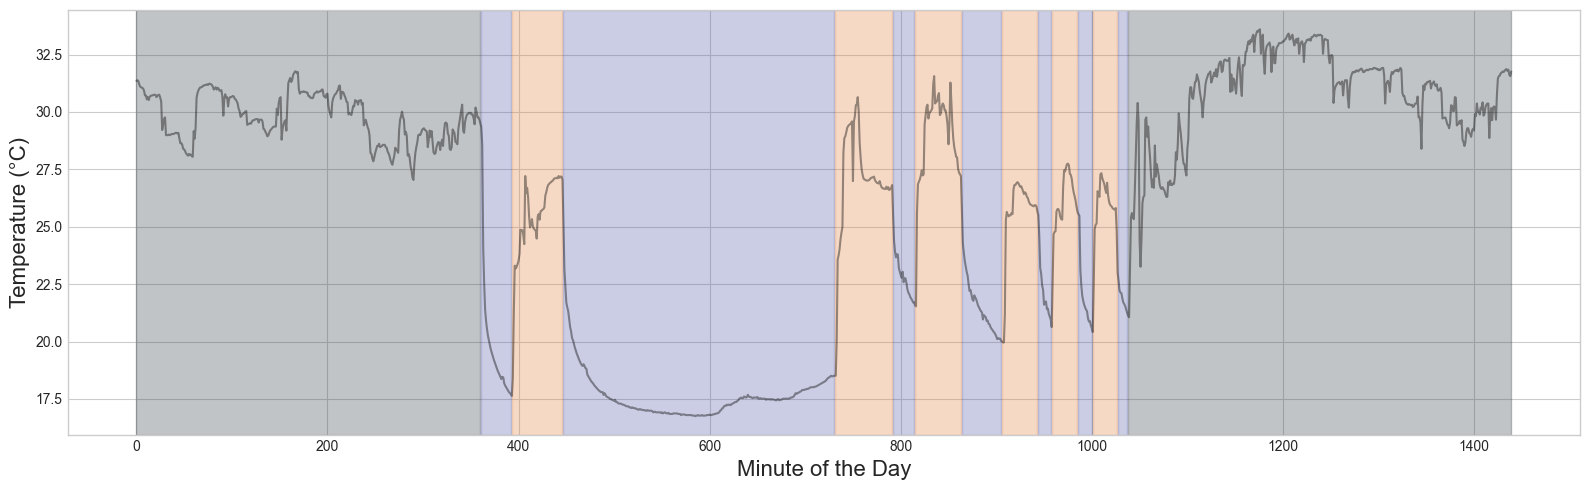

In [19]:
# Ejemplo de un día
plt.style.use("seaborn-v0_8-whitegrid")
i = random.randint(0, len(X_array) - 1)
X = X_array[i]
y = y_array[i]
labels = le.inverse_transform(y)
segmentos = obtener_segmentos(labels)

plt.figure(figsize=(16, 5))
plt.plot(X[:, 0], color='black', alpha=0.4)

for start, end, label in segmentos:
    plt.axvspan(start, end, color=colors[label], alpha=0.3, label=label)

# Para evitar duplicados en la leyenda
handles, labels_unique = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_unique, handles))
#plt.legend(by_label.values(), by_label.keys(), title="Etiqueta")

#plt.title(f"Day {i}", fontsize=10)
plt.xlabel("Minute of the Day", fontsize=16)
plt.ylabel("Temperature (°C)", fontsize=16)
plt.tight_layout()
#plt.savefig("figures/figure_1.png", dpi=300)
plt.show()

Defining a "Dataset" class to wrap daily sequences and enable easy sampling and batching.

In [22]:
class NestEventDataset(Dataset):
    def __init__(self, X_array, y_array):
        self.X_array = X_array
        self.y_array = y_array

    def __len__(self):
        return len(self.X_array)

    def __getitem__(self, idx):
        X = self.X_array[idx].astype(np.float32)
        y = self.y_array[idx].astype(np.int64)
        return torch.tensor(X), torch.tensor(y)

# ===  Krear datset i seleksionar un índise aleatorio ===
dataset = NestEventDataset(X_array, y_array)
idx = random.randint(0, len(dataset) - 1)
X_sample, y_sample = dataset[idx]
X_np = X_sample.numpy()
y_np = y_sample.numpy()

Total "days" made after split

In [23]:
print(f"Número total de días (entradas): {len(dataset)}")

Número total de días (entradas): 4658


### Filter and clean daily sequences
We apply a multi-step cleaning process to ensure high-quality training data:
1. Remove days containing the 'Error' class (label 0).
2. Remove days with no behavioral variation (only one unique label).
3. Keep only full-length sequences (1,440 minutes per day).

Finally, we reindex the labels to start from 0 (i.e., On=0, Off=1, Nocturnal=2) and rebuild the PyTorch dataset. This guarantees consistent input format and label structure for model training.

In [24]:
# 1. Bórrar dias kon klase 'Error' (kódigo 0)
mascara_sin_error = np.array([0 not in y for y in y_array])
X_array = X_array[mascara_sin_error]
y_array = y_array[mascara_sin_error]

# 2. Bórrar dias ke solo tienen una klase
indices_validos = [i for i, y in enumerate(y_array) if len(np.unique(y)) > 1]
# Aplicar filtrado
X_array = X_array[indices_validos]
y_array = y_array[indices_validos]

# 3. Bórrar dias ande no ay datos kompletos
longitud_deseada = 1440
mascara_largo = np.array([len(y) == longitud_deseada for y in y_array])
X_array = X_array[mascara_largo]
y_array = y_array[mascara_largo]

# Linya de resekuensiasyon
y_array = [np.array([label - 1 for label in seq]) for seq in y_array]

# Despues...
dataset = NestEventDataset(X_array, y_array)


In [47]:
np.save("X_array_cleaned.npy", X_array, allow_pickle=True)
np.save("y_array_cleaned.npy", y_array, allow_pickle=True)

# Guardar clases del LabelEncoder
with open("label_classes.npy", "wb") as f:
    np.save(f, le.classes_)

Total number of valid nest-days available for training and testing after cleanning.

In [25]:
print(f"Numero total de dias (entradas): {len(y_array)}")

Número total de días (entradas): 2232


We extract one random daily sequence to inspect or visualize input and label structure and the visualize it

In [26]:
idx = random.randint(0, len(X_array) - 1)
X_sample = X_array[idx].astype(np.float32)
y_sample = y_array[idx].astype(np.int64)

X_np = X_sample
y_np = y_sample

In [27]:
y_np

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
y_array

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0,

## Define BiLSTM model architecture

Define and train our initial deep learning model using a hold-out strategy (80% training, 20% validation). We start by implementing a custom `BiLSTMModel` class, which uses a two-layer bidirectional LSTM architecture to learn temporal patterns from nest temperature sequences. Each input consists of 1,440 time steps with three features: internal nest temperature, ambient temperature, and sine-transformed time of day. The model outputs one behavioral prediction per minute using a final dense layer.

We wrap our cleaned dataset with a custom PyTorch `Dataset` class, and split the data using `train_test_split` to ensure reproducibility. Data is loaded in batches of 16 for both training and validation.

The model is trained over 100 epochs using the Adam optimizer and cross-entropy loss. After each epoch, validation loss and accuracy are computed, and the best-performing model (lowest validation loss) is saved to disk.

In [34]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [30]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        return out

In [32]:
class NestEventDataset(Dataset):
    def __init__(self, X_array, y_array):
        self.X_array = X_array
        self.y_array = y_array

    def __len__(self):
        return len(self.X_array)

    def __getitem__(self, idx):
        X = self.X_array[idx].astype(np.float32)
        y = self.y_array[idx].astype(np.int64)
        return torch.tensor(X), torch.tensor(y)

dataset = NestEventDataset(X_array, y_array)

# Split (opcional)
from sklearn.model_selection import train_test_split
indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=57)

train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [33]:
input_size = X_array[0].shape[1]  # número de features por minuto (ej: temperatura, ambiente, etc.)
hidden_size = 64
num_layers = 2
num_classes = 3  # ['Nocturnal', 'Off', 'On']

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
best_val_loss = float('inf')  # inicializar mejor pérdida
best_model_path = "modelos/modelo_bilstm_mejor_final.pth"
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)

        outputs = outputs.view(-1, outputs.shape[-1])
        y_batch = y_batch.view(-1)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # === VALIDACIÓN ===
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)

            outputs = outputs.view(-1, outputs.shape[-1])
            y_val = y_val.view(-1)

            val_loss += criterion(outputs, y_val).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_val).sum().item()
            total += y_val.numel()

    val_loss_epoch = val_loss / len(val_loader)
    val_acc_epoch = correct / total

    # === ✅ Guardar el mejor modelo ===
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Guardado mejor modelo en epoch {epoch+1} con Val Loss: {val_loss_epoch:.4f}")

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss / len(train_loader):.4f} - "
          f"Val Loss: {val_loss_epoch:.4f} - "
          f"Val Accuracy: {val_acc_epoch:.4f}")

✅ Guardado mejor modelo en epoch 1 con Val Loss: 0.4494
Epoch 1/100 - Train Loss: 0.8042 - Val Loss: 0.4494 - Val Accuracy: 0.8377
✅ Guardado mejor modelo en epoch 2 con Val Loss: 0.4040
Epoch 2/100 - Train Loss: 0.4835 - Val Loss: 0.4040 - Val Accuracy: 0.8482
✅ Guardado mejor modelo en epoch 3 con Val Loss: 0.3350
Epoch 3/100 - Train Loss: 0.3643 - Val Loss: 0.3350 - Val Accuracy: 0.8780
✅ Guardado mejor modelo en epoch 4 con Val Loss: 0.2580
Epoch 4/100 - Train Loss: 0.3068 - Val Loss: 0.2580 - Val Accuracy: 0.9104
Epoch 5/100 - Train Loss: 0.3104 - Val Loss: 0.3877 - Val Accuracy: 0.8450
✅ Guardado mejor modelo en epoch 6 con Val Loss: 0.2578
Epoch 6/100 - Train Loss: 0.3270 - Val Loss: 0.2578 - Val Accuracy: 0.9144
✅ Guardado mejor modelo en epoch 7 con Val Loss: 0.2346
Epoch 7/100 - Train Loss: 0.2704 - Val Loss: 0.2346 - Val Accuracy: 0.9215
Epoch 8/100 - Train Loss: 0.2935 - Val Loss: 0.2432 - Val Accuracy: 0.9157
✅ Guardado mejor modelo en epoch 9 con Val Loss: 0.2165
Epoch 9/

Above you can see the performance by epoch and how it improves across the time...

### Model evaluation and performance metrics

After training, we evaluate the BiLSTM model on the validation set using both standard classification metrics and probabilistic curves. First, we compute per-class precision, recall, and F1-score, and visualize the confusion matrix to identify misclassification patterns. Next, we calculate precision–recall (PR) curves using both micro- and macro-averaging, and compute the average precision (AP) for each behavioral class: `Nocturnal`, `Off`, and `On`.

To improve interpretability, we extract the softmax outputs (class probabilities) and use them to generate high-resolution PR curves. These plots help assess how confidently the model distinguishes between classes and reveal any imbalance in prediction strength. We inspect the internal structure of the model, printing trainable parameters and visualizing the weights from both LSTM layers and the fully connected output layer. This provides insights into model complexity and potential areas for optimization.

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [38]:
model.eval()
all_preds = []
all_labels = []

In [39]:
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)

        outputs = torch.argmax(outputs, dim=2)  # (batch_size, seq_len)

        all_preds.extend(outputs.cpu().numpy().reshape(-1))
        all_labels.extend(y_val.cpu().numpy().reshape(-1))

# === Clasificación y matriz de confusión ===
label_names = ['Nocturnal', 'Off', 'On']

=== Classification Report ===
              precision    recall  f1-score   support

   Nocturnal       0.97      0.98      0.98    322871
         Off       0.93      0.95      0.94    116631
          On       0.96      0.94      0.95    204178

    accuracy                           0.96    643680
   macro avg       0.96      0.96      0.96    643680
weighted avg       0.96      0.96      0.96    643680



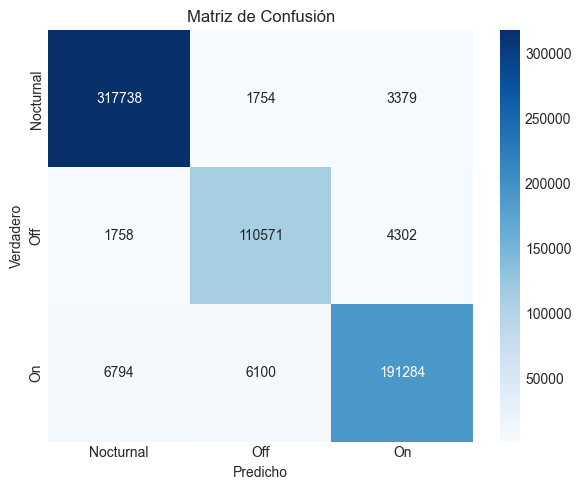

In [40]:
print("=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=label_names, zero_division=0))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicho")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import PrecisionRecallDisplay
from itertools import cycle

In [42]:
# 1. Convert labels and predictions to binary format for each class
# Labels must be in {0, 1, 2} for 3-class classification nocturnal, on, off
n_classes = 3
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
y_pred_bin = label_binarize(all_preds, classes=[0, 1, 2])  # Use this only if you don't have probabilities

# Better: Use model probabilities instead of hard predictions (softmax output)
# y_proba should be a numpy array of shape (num_samples, n_classes) !!! care bro
# Here’s how you could obtain it if you still have your model and val_loader... hehehe

y_true_bin = []
y_scores = []

model.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        outputs = model(X_val)  # shape: (batch_size, seq_len, num_classes)
        probs = torch.softmax(outputs, dim=-1)  # softmax along last dim

        y_scores.append(probs.cpu().numpy().reshape(-1, n_classes))
        y_true_bin.append(label_binarize(y_val.cpu().numpy().reshape(-1), classes=[0, 1, 2]))

y_scores = np.vstack(y_scores)
y_true_bin = np.vstack(y_true_bin)

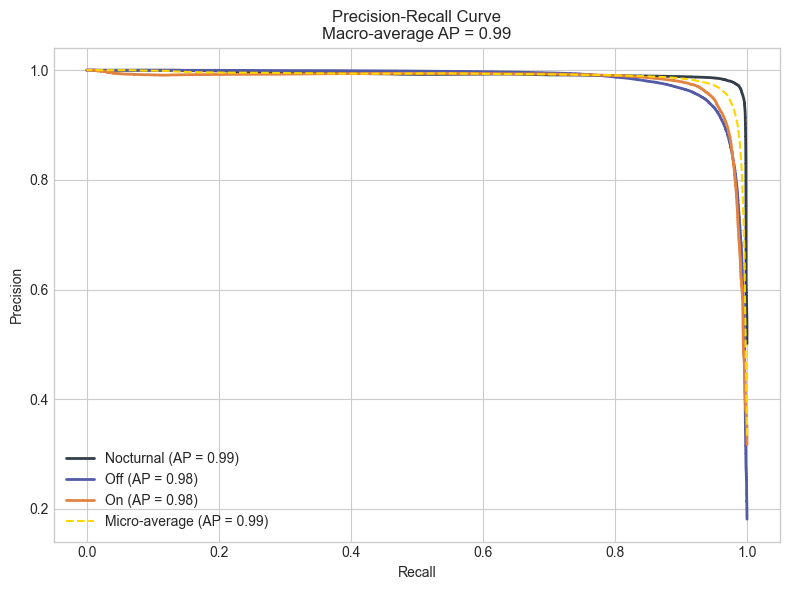

In [43]:
# Assuming y_true_bin and y_scores are already defined as above
n_classes = y_true_bin.shape[1]

# Micro-average
precision_micro, recall_micro, _ = precision_recall_curve(y_true_bin.ravel(), y_scores.ravel())
average_precision_micro = average_precision_score(y_true_bin, y_scores, average="micro")

# Macro-average (compute separately for each class and then average)
precision_macro = dict()
recall_macro = dict()
average_precision_macro = []

for i in range(n_classes):
    precision_macro[i], recall_macro[i], _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_scores[:, i])
    average_precision_macro.append(ap)

average_precision_macro = np.mean(average_precision_macro)

# === Plot ===
plt.figure(figsize=(8, 6))
colors = cycle(['#333E48', '#535AA6', '#E28342'])
label_names = ['Nocturnal', 'Off', 'On']

# Per class
for i, color in zip(range(n_classes), colors):
    plt.plot(recall_macro[i], precision_macro[i], lw=2, color=color,
             label=f"{label_names[i]} (AP = {average_precision_score(y_true_bin[:, i], y_scores[:, i]):.2f})")

# Micro
plt.plot(recall_micro, precision_micro, linestyle='--', color='gold',
         label=f"Micro-average (AP = {average_precision_micro:.2f})")

# Macro (optional, just as text if curves already plotted above)
plt.title(f"Precision-Recall Curve\nMacro-average AP = {average_precision_macro:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
print(model)

BiLSTMModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Número total de parámetros entrenables: {count_parameters(model):,}")

Número total de parámetros entrenables: 135,043


In [46]:
# Pesos y bias del primer LSTM layer
print("LSTM - Peso input-hidden layer 0:\n", model.lstm.weight_ih_l0)
print("LSTM - Peso hidden-hidden layer 0:\n", model.lstm.weight_hh_l0)

# Si es bidireccional, también puedes ver la dirección inversa
print("LSTM - Peso input-hidden reverse layer 0:\n", model.lstm.weight_ih_l0_reverse)

# Capa final (fully connected)
print("FC - Peso:\n", model.fc.weight)
print("FC - Bias:\n", model.fc.bias)

LSTM - Peso input-hidden layer 0:
 Parameter containing:
tensor([[-3.2114e-02, -1.8106e-01,  4.1493e-01],
        [-7.5189e-02, -1.3933e-02,  3.2754e-01],
        [-4.2508e-02, -5.4104e-02, -1.1991e-02],
        [ 6.2689e-02,  1.6690e-01,  3.8205e-02],
        [-1.3118e-01, -3.4174e-02, -6.2935e-02],
        [-1.1683e-01, -8.2700e-02,  4.7947e-01],
        [ 1.7296e-02, -6.2871e-02, -3.1849e-01],
        [-6.0703e-02, -1.1238e-01, -1.1069e-01],
        [ 8.3236e-02,  1.4629e-01,  1.9570e-01],
        [ 5.5535e-02, -3.2720e-02, -1.7970e-01],
        [-6.3546e-02, -1.9483e-01,  2.4210e-02],
        [ 1.0018e-01, -2.9324e-01,  1.5687e-01],
        [ 2.0325e-01,  6.1676e-02,  2.5488e-01],
        [-8.5384e-02, -3.0594e-02, -1.3824e-01],
        [-1.1582e-01, -6.1194e-02,  3.4104e-01],
        [-2.2079e-01,  7.8811e-02, -9.3425e-02],
        [ 1.0495e-01,  9.0385e-02, -2.9118e-01],
        [-1.4783e-01,  7.2945e-02,  3.6026e-01],
        [-1.1521e-01, -1.2517e-03,  3.1965e-01],
        [ 5.

Please go to the next, [Supplementary 2](https://github.com/jorgelizarazo94/BoutScout_Model/blob/0606dd4bc07a29e72a9ef2ba26c2491d38412b84/supplementary_2.ipynb)
